In [ ]:
# SUBMITTED BY Shikhar Jain CS22MTECH02002
#NOTE: R2 or r2 is coefficient of determination 
# to solve adding problem using different RNN's i used this refrence : https://minpy.readthedocs.io/en/latest/tutorial/rnn_tutorial/rnn_tutorial.html

time: 317 µs (started: 2023-04-10 11:31:38 +00:00)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score
import warnings
import time # to see execution time of each cell in colab notebook
warnings.filterwarnings("ignore")
np.random.seed(42)

time: 1.11 ms (started: 2023-04-10 11:31:39 +00:00)


#***DATASET CREATION***

In [ ]:
data_set_param_dict={'num_samples':5000,
'train_set_ratio':0.8, # less than 1
'test_set_ratio':0.2,# less than 1
'min_length_sequence':2,
'max_length_sequence':15,
'preffered_max_length':9 # thus more "length" samples will be generated from subrange [a,c] with in the range [a,b] where a=min_length & b=max_length
}

time: 344 µs (started: 2023-04-10 11:38:15 +00:00)


In [ ]:
def generate_length_samples1(num_samples,min_length_sequence,max_length_sequence,preffered_max_length,unpreffered_samples=500):
  # using randint and sampling untill a fixed number of "unpreffered" length samples are not generated
  gen_sample_count=0
  #pf_count=0
  unpf_count=0  
  #prefrred_samples_tot=num_samples-unpreffered_samples
  preffred_sample=[]
  unpreffered_sample=[]
  while gen_sample_count<=num_samples:
    x = random.randint(min_length_sequence, max_length_sequence)
    #print("**",x)
    if x <= preffered_max_length:
      preffred_sample.append(x)
      gen_sample_count+=1
      #pf_count+=1      
    else:
      if unpf_count<=unpreffered_samples:
        unpreffered_sample.append(x)
        unpf_count+=1
        gen_sample_count+=1

  #print(preffred_sample)
  final_list=preffred_sample+unpreffered_sample
  return random.sample(final_list,len(final_list))

def generate_length_samples2(num_samples,min_length_sequence,max_length_sequence,preffered_max_length,unpreffered_samples=100):
  # this technique will use beta-distribution to favour a particular sub range
  # Compute alpha and beta parameters of the beta distribution
    alpha = preffered_max_length - min_length_sequence + 1
    beta = max_length_sequence - preffered_max_length + 1
    
    gen_sample_count=0
    #pf_count=0
    unpf_count=0  
    #prefrred_samples_tot=num_samples-unpreffered_samples
    preffred_sample=[]
    unpreffered_sample=[]
    while gen_sample_count<=num_samples:
    
      # Generate a random sample from the beta distribution
      sample=np.random.beta(alpha, beta)
    
      # Map the sample to an integer within the range [a, b]
      x=int(round(min_length_sequence + sample * (max_length_sequence - min_length_sequence)))
      if x <= preffered_max_length:
        preffred_sample.append(x)
        gen_sample_count+=1
        #pf_count+=1      
      else:
        if unpf_count<=unpreffered_samples:
          unpreffered_sample.append(x)
          unpf_count+=1
          gen_sample_count+=1
    final_list=preffred_sample+unpreffered_sample
    return random.sample(final_list,len(final_list))      



time: 1.78 ms (started: 2023-04-10 11:31:41 +00:00)


In [ ]:
def generate_dataset(data_set_param_dict,generate_length_samples=generate_length_samples1):
  length_samples=generate_length_samples1(data_set_param_dict['num_samples'],
                                          data_set_param_dict['min_length_sequence'],
                                          data_set_param_dict['max_length_sequence'],
                                          data_set_param_dict['preffered_max_length']
                                          )
  
  dataset=[]#list of tuples
  #float_samples=[] # this can't be converted into numpy array due to differnt sequence sizes
  #bool_samples=[] # this can't be converted into numpy array due to differnt sequence sizes
  for i in range(data_set_param_dict['num_samples']):
    float_samples=np.random.uniform(0,1,size=(1, length_samples[i]))
    bool_samples=np.zeros((1, length_samples[i]), dtype=int)
    on_idxs = random.sample(range(length_samples[i]), 2)
    y=0.0
    for j in on_idxs:
      bool_samples[0][j] = 1
      y+=float_samples[0][j]
    dataset.append((float_samples,bool_samples,y)) 
  
  return dataset


time: 806 µs (started: 2023-04-10 11:31:48 +00:00)


In [ ]:
dataset=generate_dataset(data_set_param_dict)

# ***Visualizing sequence length-distribution and Output-distribution***

In [ ]:
def input_seq_length_dist(dataset):
  seq_length=[]
  for datapoint in dataset:
    seq_length.append(datapoint[0].shape[1])
  bins=np.arange(data_set_param_dict['min_length_sequence'],data_set_param_dict['max_length_sequence'],1)
  #print(seq_length)
  plt.xlim([min(seq_length), max(seq_length)+2])
  plt.hist(seq_length,bins=bins,alpha=0.5)
  plt.title('Input sequence length distribution')
  plt.xlabel('length bins')
  plt.ylabel('sample count')
  plt.show()

def input_seq_y_label_dist(dataset):
  seq_output=[]
  for datapoint in dataset:
    seq_output.append(datapoint[2])
  #x_ticks=np.linspace(0,2,100)
  #print(seq_length)
  bins=np.linspace(0,2,100)
  #plt.xlim([min(seq_output), max(seq_length)+2])
  plt.hist(seq_output,bins=bins)
  plt.title('Input sequece sum distribution')
  plt.xlabel('Y-labels')
  plt.ylabel('sample count')
  plt.show()
  

time: 3.44 ms (started: 2023-04-10 11:31:50 +00:00)


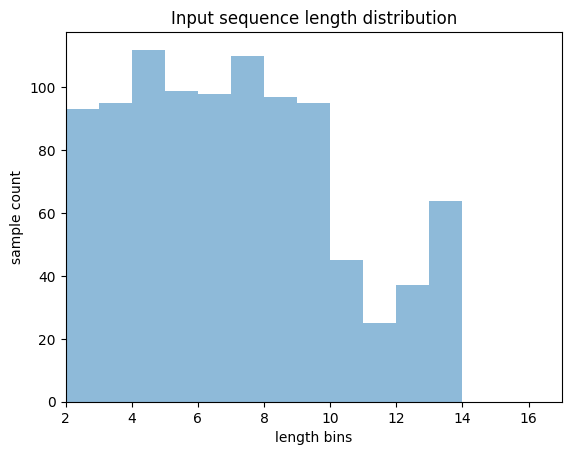

time: 440 ms (started: 2023-04-10 11:31:52 +00:00)


In [ ]:
input_seq_length_dist(dataset)

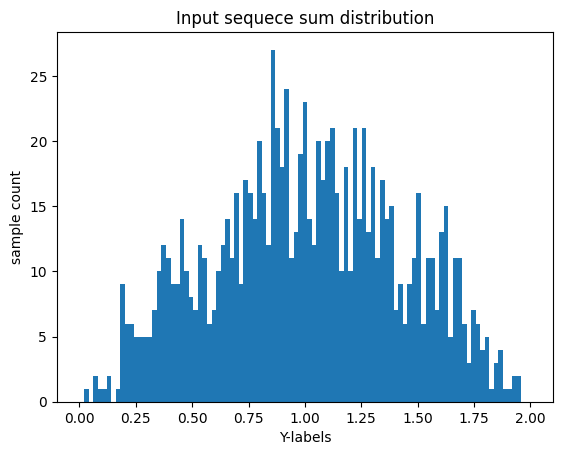

time: 480 ms (started: 2023-04-10 11:31:53 +00:00)


In [ ]:
input_seq_y_label_dist(dataset)

In [ ]:
dataset_beta=generate_dataset(data_set_param_dict,generate_length_samples2)

time: 68.3 ms (started: 2023-04-10 11:31:54 +00:00)


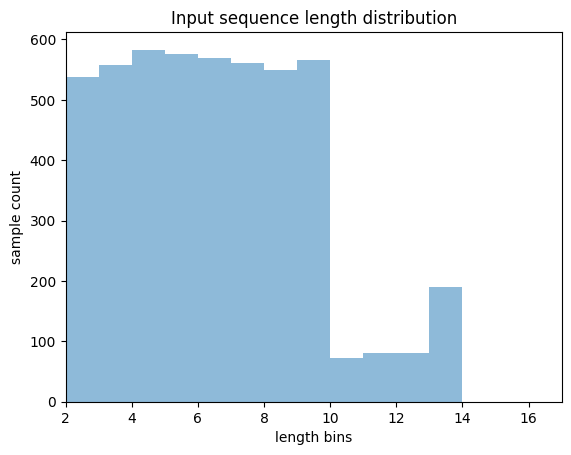

time: 263 ms (started: 2023-04-10 11:31:55 +00:00)


In [ ]:
input_seq_length_dist(dataset_beta)

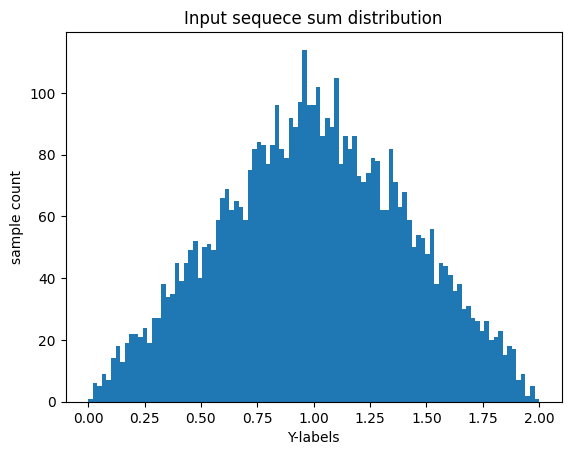

time: 414 ms (started: 2023-04-10 11:31:57 +00:00)


In [ ]:
input_seq_y_label_dist(dataset_beta)

#***Divide data in train and test set***

In [ ]:
dataset=random.sample(dataset,len(dataset))#shuffling the dataset
train=dataset[0:int(data_set_param_dict['train_set_ratio']*len(dataset))]
test=dataset[int(data_set_param_dict['train_set_ratio']*len(dataset)):]

time: 1.35 ms (started: 2023-04-10 11:31:58 +00:00)


In [ ]:
#print(int(data_set_param_dict['train_set_ratio']*len(dataset)))

time: 285 µs (started: 2023-04-10 11:31:58 +00:00)


# ***Taking Baseline as '1.0' i.e taking a baseline model whose output is always '1.0'. This baseline will be used for both test and train***

In [ ]:
baseline_mse_train=0.0
baseline_mse_test=0.0
baseline_r2_train=0.0
baseline_r2_test=0.0
baseline_prediction=1.0

actual_test=[]
actual_train=[]
for datapoint in train:
  baseline_mse_train+=(datapoint[2]-baseline_prediction)**2
  actual_train.append(datapoint[2])
  #baseline_r2_train+=1 if abs(datapoint[2]-baseline_prediction)<0.01 else 0

baseline_mse_train=baseline_mse_train/len(train)
baseline_r2_train=r2_score(actual_train,[1.0]*len(actual_train))
for datapoint in test:
  baseline_mse_test+=(datapoint[2]-baseline_prediction)**2
  actual_test.append(datapoint[2])
  #baseline_r2_test+=1 if abs(datapoint[2]-baseline_prediction)<0.01 else 0
baseline_mse_test=baseline_mse_test/len(test)
baseline_r2_test=r2_score(actual_test,[1.0]*len(actual_test))


In [ ]:
print("**** BASELINE MSE FOR TRAIN & TEST DATASET SPLIT :",round(baseline_mse_train,4),round(baseline_mse_test,4), " ***** ")
print("**** BASELINE R2_Score FOR TRAIN & TEST DATASET SPLIT :",round(baseline_r2_train,4),round(baseline_r2_test,4), " ***** ")

**** BASELINE MSE FOR TRAIN & TEST DATASET SPLIT : 0.1708 0.1872  ***** 
**** BASELINE R2_Score FOR TRAIN & TEST DATASET SPLIT : -0.0015 -0.0003  ***** 
time: 763 µs (started: 2023-04-10 11:32:01 +00:00)


In [ ]:
#change the data-structure of both train & test dataset
train_data=[] # a list of list of np.array of size(1,2)
test_data=[] # a list of list of np.array of size(1,2)
for datapoint in train:
  length=datapoint[0].shape[1]
  temp=[]  
  for i in range(length):
    temp.append(np.array([datapoint[0][0][i],datapoint[1][0][i]]).reshape(2))
  train_data.append((np.array(temp).reshape(len(temp),2),datapoint[2]))

for datapoint in test:
  length=datapoint[0].shape[1]
  temp=[]
  for i in range(length):
    temp.append(np.array([datapoint[0][0][i],datapoint[1][0][i]]).reshape(1,2))
  test_data.append((np.array(temp).reshape(len(temp),2),datapoint[2]))  


time: 35.2 ms (started: 2023-04-10 11:32:03 +00:00)


In [ ]:
def train_rnn(model_object,train_data,input_seq_size,hidden_state_size,output_size,max_epochs=100,learning_rate=0.001,r2_tol=0.95,relative_loss_tol=0.001):
  start_time=time.perf_counter()
  model=model_object(input_seq_size=input_seq_size, hidden_state_size=hidden_state_size, output_size=output_size) # these set of hyperparametrs seems to perform much better
  #print([x for x in  model.parameters()])
  model=model.float()
  optimizer=optim.Adam(model.parameters(),lr=learning_rate,betas=(0.9, 0.999))
  loss_fn = nn.MSELoss()
  loss=0.0
  #max_epochs = max_epochs
  train_loss_per_epoch=[]
  test_loss_per_epoch=[]
  train_r2_per_epoch=[]
  test_r2_per_epoch=[]
  convergence_epochs=max_epochs
  predicted=[]
  actual=[]
  

  for epoch in range(max_epochs):
      predicted=[]
      actual=[]
      #shuffle train_data
      print(" ***** Executing Epoch : {} ******".format(epoch+1))
      train_data=random.sample(train_data,len(train_data))
      # Train the model on the training set
      model.train() # switch on the train mode
      train_loss = 0
      #train_acc = 0
      loss=0
      for i in range(len(train_data)):
          optimizer.zero_grad()
          output = model(torch.from_numpy(train_data[i][0]).float())# giving the array of shape (time,2)
          #print("**",output)
          predicted.append(output.detach().numpy()[0][0])
          actual.append(train_data[i][1])
          
          loss = loss_fn(output,torch.tensor(train_data[i][1]).float())
          loss.backward()
          optimizer.step()
          train_loss += loss.item()
          #train_acc += 1 if abs(loss/train_data[i][1])<=r2_tol else 0 # if prediction is <= 5% of the true label
      #print(predicted)
      r2=r2_score(actual,predicted)
      print(" ^^^^ Train Loss : {} & Train R2 : {} ^^^^^".format(train_loss/len(train_data),r2))    
      train_loss_per_epoch.append(train_loss/len(train_data)) # MSE
      #train_accuracy_per_epoch.append(train_acc/len(train_data)) # mean accuracy
      train_r2_per_epoch.append(r2) # since "Accuracy" for regression model doesnt make any sense hence R2 is calculated
      if len(train_loss_per_epoch)>5:
        diff1=(abs(train_loss_per_epoch[-5]-train_loss_per_epoch[-4])/train_loss_per_epoch[-4])+(abs(train_loss_per_epoch[-4]-train_loss_per_epoch[-3])/train_loss_per_epoch[-3])+(abs(train_loss_per_epoch[-3]-train_loss_per_epoch[-2])/train_loss_per_epoch[-2])+(abs(train_loss_per_epoch[-2]-train_loss_per_epoch[-1])/train_loss_per_epoch[-1])+(abs(train_loss_per_epoch[-2]-train_loss_per_epoch[-1])/train_loss_per_epoch[-1])
        if (diff1/5)<=relative_loss_tol:
          convergence_epochs=epoch+1      
          break
      if len(train_r2_per_epoch)>5:
        summ1=train_r2_per_epoch[-5]+train_r2_per_epoch[-4]+train_r2_per_epoch[-3]+train_r2_per_epoch[-2]+train_r2_per_epoch[-1]
        if (summ1/5)>=r2_tol:
          convergence_epochs=epoch+1
          break
  end_time=time.perf_counter()        
  return (model,train_loss_per_epoch,train_r2_per_epoch,convergence_epochs,end_time-start_time)         

time: 1.98 ms (started: 2023-04-10 11:32:03 +00:00)


In [ ]:
def plot_learning_curves(max_epochs,train_loss_per_epoch,train_r2_per_epoch,model_name,baseline_mse_train=baseline_mse_train,baseline_r2_train=baseline_r2_train):
  fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,10))
  plt.subplots_adjust(wspace=0.3)
  ax[0].plot(range(max_epochs),train_loss_per_epoch)
  ax[0].plot(range(max_epochs),[baseline_mse_train]*max_epochs,c='r')
  ax[0].set_title("Loss per Epoch | Baseline MSE: {}".format(round(baseline_mse_train,3)))
  ax[0].set_xlabel("Epochs")
  ax[0].set_ylabel("Mean Loss")
  ax[1].plot(range(max_epochs),train_r2_per_epoch)
  ax[1].plot(range(max_epochs),[baseline_r2_train]*max_epochs,c='r')
  ax[1].set_title("R2 per Epoch | Baseline R2: {}".format(round(baseline_r2_train,3)))
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("R2")
  fig.suptitle("{} LEARNING PERFORMANCE ON TRAIN DATASET\nRED LINE REPRESENTS BASELINE Metrics\nCONVERGENCE ACHIEVED AT :{} EPOCHS".format(model_name,max_epochs),fontweight='bold')


time: 879 µs (started: 2023-04-10 11:32:10 +00:00)


In [ ]:
def model_eval(model,train_data,test_data,baseline_mse_test=baseline_mse_test):
  model.eval()
  with torch.no_grad():
    train_actual_label=[]
    test_actual_label=[]
    train_predicted_label=[]
    test_predicted_label=[]
    for datapoint in train_data:
      train_predicted_label.append(model(torch.from_numpy(datapoint[0]).float()))
      train_actual_label.append(datapoint[1])
    for datapoint in test_data:
      test_predicted_label.append(model(torch.from_numpy(datapoint[0]).float()))
      test_actual_label.append(datapoint[1])

  train_mse=0.0
  test_mse=0.0
  test_r2=r2_score(test_actual_label,test_predicted_label)
  #actual=[]
  #predicted=[]
  for y,y1 in zip(train_actual_label,train_predicted_label):
    train_mse+=(y-y1)**2
  train_mse/=len(train_actual_label)
  for y,y1 in zip(test_actual_label,test_predicted_label):
    test_mse+=(y-y1)**2
    #test_accuracy+=1 if (abs(y-y1)/y)<=0.02 else 0
  test_mse/=len(test_actual_label)

  fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,10))
  plt.subplots_adjust(wspace=0.3)
  ax[0].scatter(train_actual_label,train_predicted_label)
  ax[0].plot(train_actual_label,[1.0]*len(train_actual_label),c='r')
  ax[0].set_title("Train Performance with MSE = {}".format(train_mse))
  ax[0].set_xlabel("Actual Score (Train set)")
  ax[0].set_ylabel("Predicted Score")
  ax[1].scatter(test_actual_label,test_predicted_label)
  ax[1].plot(test_actual_label,[1.0]*len(test_actual_label),c='r')
  ax[1].set_title("Test Performance with MSE = {}\nBASELINE TEST MSE : {}".format(test_mse,round(baseline_mse_test,3)))
  ax[1].set_xlabel("Actual Score (Test set)")
  ax[1].set_ylabel("Predicted Score")
  return test_mse,test_r2

time: 1.21 ms (started: 2023-04-10 11:32:11 +00:00)


In [ ]:
def model_eval_large_sequences(model,model_name):
  large_sequences_train={}
  large_sequences_test={}

  for datapoint in train_data:
    if datapoint[0].shape[0]>data_set_param_dict['preffered_max_length']:      
      if str(datapoint[0].shape[0]) not in large_sequences_train.keys():
        large_sequences_train[str(datapoint[0].shape[0])]=[]
      else:
        large_sequences_train[str(datapoint[0].shape[0])].append(datapoint)

  for datapoint in test_data:
    if datapoint[0].shape[0]>data_set_param_dict['preffered_max_length']:      
      if str(datapoint[0].shape[0]) not in large_sequences_test.keys():
        large_sequences_test[str(datapoint[0].shape[0])]=[]
      else:
        large_sequences_test[str(datapoint[0].shape[0])].append(datapoint) 

  #print(large_sequences)
  predicted_for_large_sequences_train={}
  actual_for_large_sequences_train={}
  predicted_for_large_sequences_test={}
  actual_for_large_sequences_test={}
  model.eval()
  
  for k in large_sequences_train.keys():
    predicted_for_large_sequences_train[k]=[]
    actual_for_large_sequences_train[k]=[]

  for k in large_sequences_test.keys():
    predicted_for_large_sequences_test[k]=[]
    actual_for_large_sequences_test[k]=[] 

  with torch.no_grad():
    for k in large_sequences_train.keys():
      for datapoint in large_sequences_train[k]:
        predicted_for_large_sequences_train[k].append(model(torch.from_numpy(datapoint[0]).float()))
        actual_for_large_sequences_train[k].append(datapoint[1])
    for k in large_sequences_test.keys():
      for datapoint in large_sequences_test[k]:
        predicted_for_large_sequences_test[k].append(model(torch.from_numpy(datapoint[0]).float()))
        actual_for_large_sequences_test[k].append(datapoint[1])    

  
  train_keys=list(predicted_for_large_sequences_train.keys())
  test_keys=list(predicted_for_large_sequences_test.keys())
  
  fig,ax=plt.subplots(nrows=(data_set_param_dict['max_length_sequence']-data_set_param_dict['preffered_max_length'])//2,ncols=2,figsize=(20,10))
  plt.subplots_adjust(wspace=0.3,hspace=0.5)
  fig.suptitle("{} Performance on Large Length Sequence(> {} )\nFOR TRAIN DATASET".format(model_name,data_set_param_dict['preffered_max_length']),fontweight='bold')
  for i in range((data_set_param_dict['max_length_sequence']-data_set_param_dict['preffered_max_length'])//2):
    idx=2*i
    ax[i][0].scatter(actual_for_large_sequences_train[train_keys[idx]],predicted_for_large_sequences_train[train_keys[idx]])
    ax[i][0].plot(actual_for_large_sequences_train[train_keys[idx]],[1.0]*len(actual_for_large_sequences_train[train_keys[idx]]),c='r')
    ax[i][0].set_title("Length : {}".format(train_keys[idx]))
    ax[i][0].set_xlabel("Actual Score (Train set)")
    ax[i][0].set_ylabel("Predicted Score")
    idx=2*i+1
    ax[i][1].scatter(actual_for_large_sequences_train[train_keys[idx]],predicted_for_large_sequences_train[train_keys[idx]])
    ax[i][1].plot(actual_for_large_sequences_train[train_keys[idx]],[1.0]*len(actual_for_large_sequences_train[train_keys[idx]]),c='r')
    ax[i][1].set_title("Length : {}".format(train_keys[idx]))
    ax[i][1].set_xlabel("Actual Score (Train set)")
    ax[i][1].set_ylabel("Predicted Score")
  #plt.close()

  fig,ax=plt.subplots(nrows=(data_set_param_dict['max_length_sequence']-data_set_param_dict['preffered_max_length'])//2,ncols=2,figsize=(20,10))
  fig.suptitle("{} Performance on Large Length Sequence(> {} )\nFOR TEST DATASET".format(model_name,data_set_param_dict['preffered_max_length']),fontweight='bold')
  plt.subplots_adjust(wspace=0.3,hspace=0.5)
  for i in range((data_set_param_dict['max_length_sequence']-data_set_param_dict['preffered_max_length'])//2):
    idx=2*i
    if idx<len(test_keys):
      ax[i][0].scatter(actual_for_large_sequences_test[test_keys[idx]],predicted_for_large_sequences_test[test_keys[idx]])
      ax[i][0].plot(actual_for_large_sequences_test[test_keys[idx]],[1.0]*len(actual_for_large_sequences_test[test_keys[idx]]),c='r')
      ax[i][0].set_title("Length : {}".format(test_keys[idx]))
      ax[i][0].set_xlabel("Actual Score (TEST set)")
      ax[i][0].set_ylabel("Predicted Score")
    idx=2*i+1
    if idx<len(test_keys):
      ax[i][1].scatter(actual_for_large_sequences_test[test_keys[idx]],predicted_for_large_sequences_test[test_keys[idx]])
      ax[i][1].plot(actual_for_large_sequences_test[test_keys[idx]],[1.0]*len(actual_for_large_sequences_test[test_keys[idx]]),c='r')
      ax[i][1].set_title("Length : {}".format(test_keys[idx]))
      ax[i][1].set_xlabel("Actual Score (TEST set)")
      ax[i][1].set_ylabel("Predicted Score")
  #plt.close()    


time: 1.9 ms (started: 2023-04-10 11:32:14 +00:00)


#***Utility function to calculate jensen -shannon distance to know similarity of 2 probablity distributions***

In [ ]:
def jensenshannon_distance(model,train_data,test_data):
  import numpy as np
  from scipy.spatial.distance import jensenshannon
  prediction=[]
  actual=[]
  for datapoint in train_data:
    prediction.append(model(torch.from_numpy(datapoint[0]).float()).detach().numpy()[0][0])
    actual.append(datapoint[1])
  for datapoint in test_data:
    prediction.append(model(torch.from_numpy(datapoint[0]).float()).detach().numpy()[0][0])
    actual.append(datapoint[1])
  # generate two histograms
  hist1, bins1 = np.histogram(prediction, bins=100, range=(0.0,2.0), density=True)
  hist2, bins2 = np.histogram(actual, bins=100,range=(0.0,2.0), density=True)

  # calculate JSD
  jsd = jensenshannon(hist1, hist2)
  e1=plt.hist(prediction,bins=np.linspace(0,2,100),label="predicted")
  e2=plt.hist(actual,bins=np.linspace(0,2,100),alpha=0.5,label="actual")
  plt.legend()
  #plt.figure(figsize=(20,10))
  #print(jsd)
  plt.title("THE JENSEN - SHANNON DISTANCE BETWEEN PROBABILITY DISTRIBUTION IS : {}".format(round(jsd,3),fontweight='bold'))


time: 3.09 ms (started: 2023-04-10 11:32:17 +00:00)


#***Defining class for Elmon RNN***

In [ ]:
class Elman_RNN(nn.Module):
    def __init__(self, input_seq_size, hidden_state_size, output_size,hidden_non_linearity="tanh",output_activation="softmax"):
        super(Elman_RNN, self).__init__()
        self.input_seq_size = input_seq_size
        self.hidden_state_size = hidden_state_size
        self.weight_input_to_hidden=nn.Parameter(torch.randn(input_seq_size, hidden_state_size))
        self.weight_phidden_to_chidden=nn.Parameter(torch.randn(hidden_state_size, hidden_state_size))
        self.weight_chidden_to_output=nn.Parameter(torch.randn(hidden_state_size, output_size))
        self.current_hidden_bias = nn.Parameter(torch.randn(1,hidden_state_size))
        self.output_bias=nn.Parameter(torch.randn(1,output_size))
        self.hidden_non_linearity=None
        self.output_activation=None
        if hidden_non_linearity=="tanh":
          self.hidden_non_linearity=nn.Tanh()
        elif hidden_non_linearity=="sigmoid":
          self.hidden_non_linearity=nn.Sigmoid()
        elif hidden_non_linearity=="relu":
          self.hidden_non_linearity=nn.ReLU()

        if output_activation=="softmax":
          self.output_activation=nn.Softmax()
          

    def forward(self, input_seq):
        #seq_len=self.input_seq_size
        hidden=torch.zeros(1,self.hidden_state_size)
        # Process the input sequence one time step at a time
        for i in range(input_seq.shape[0]):           
            hidden = self.hidden_non_linearity(torch.matmul(input_seq[i],self.weight_input_to_hidden)+torch.matmul(hidden, self.weight_phidden_to_chidden) + self.current_hidden_bias)

        # Generate output after complete input sequence has been observed
        output = torch.matmul(hidden, self.weight_chidden_to_output) + self.output_bias
        #print("$$$$",output)
        return output

time: 1.18 ms (started: 2023-04-10 11:32:19 +00:00)


#It seems like taking smaller hidden state size is actually improving learning by a lot . I started trying with h=128 , 64, 32 , 16 and 16 was the best . I noticed both loss and R2 [per epoch]    ***"galloping"*** towards their best possible state as dimension of hidden state is decreased.

In [ ]:
elman_learned_model,elman_train_loss_per_epoch,elman_train_r2_per_epoch,elman_convergence_epochs,elman_convergence_time=train_rnn(model_object=Elman_RNN,train_data=train_data,input_seq_size=2,hidden_state_size=16,output_size=1)

 ***** Executing Epoch : 1 ******
 ^^^^ Train Loss : 3.2946874356009066 & Train R2 : -18.487760076068565 ^^^^^
 ***** Executing Epoch : 2 ******
 ^^^^ Train Loss : 0.5098732681381414 & Train R2 : -2.015851473558128 ^^^^^
 ***** Executing Epoch : 3 ******
 ^^^^ Train Loss : 0.2489779157709642 & Train R2 : -0.47268048661246187 ^^^^^
 ***** Executing Epoch : 4 ******
 ^^^^ Train Loss : 0.17285196505214576 & Train R2 : -0.022402790268393646 ^^^^^
 ***** Executing Epoch : 5 ******
 ^^^^ Train Loss : 0.14525219702180686 & Train R2 : 0.14084719122483125 ^^^^^
 ***** Executing Epoch : 6 ******
 ^^^^ Train Loss : 0.12997087801651938 & Train R2 : 0.23123472599647155 ^^^^^
 ***** Executing Epoch : 7 ******
 ^^^^ Train Loss : 0.12374307182486102 & Train R2 : 0.2680716019690649 ^^^^^
 ***** Executing Epoch : 8 ******
 ^^^^ Train Loss : 0.11641117771147393 & Train R2 : 0.3114390546056125 ^^^^^
 ***** Executing Epoch : 9 ******
 ^^^^ Train Loss : 0.1204181447815086 & Train R2 : 0.28773822679555616 ^^

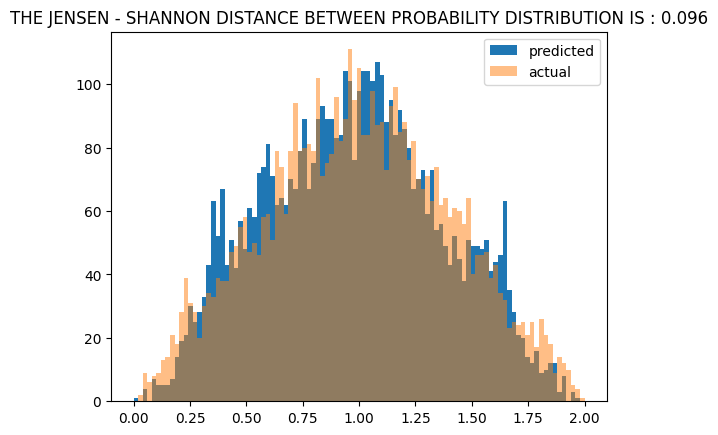

time: 2.15 s (started: 2023-04-10 11:46:44 +00:00)


In [ ]:
jensenshannon_distance(elman_learned_model,train_data,test_data)

In [ ]:
#print([x for x in elman_learned_model.parameters()][-2])

time: 312 µs (started: 2023-04-10 11:46:46 +00:00)


#***plotting loss and R2 per epoch***

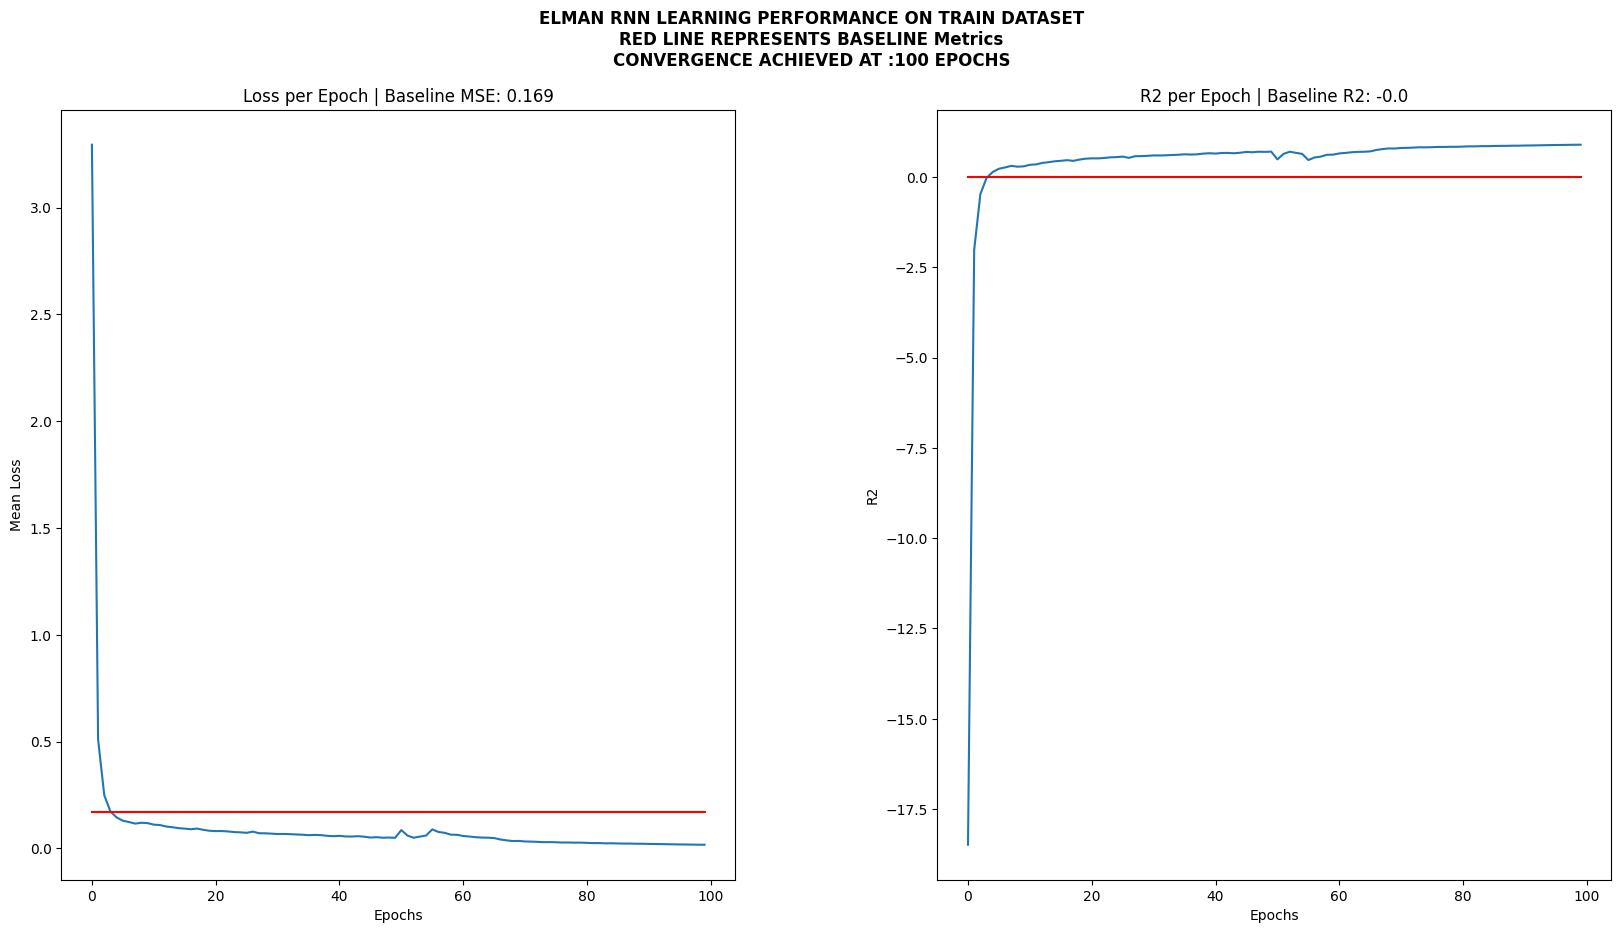

time: 458 ms (started: 2023-04-10 11:46:46 +00:00)


In [ ]:
plot_learning_curves(max_epochs=elman_convergence_epochs,train_loss_per_epoch=elman_train_loss_per_epoch,train_r2_per_epoch=elman_train_r2_per_epoch,model_name="ELMAN RNN")

# evaluating the trained elmon rnn on train and test dataset and measuring train MSE , test MSE

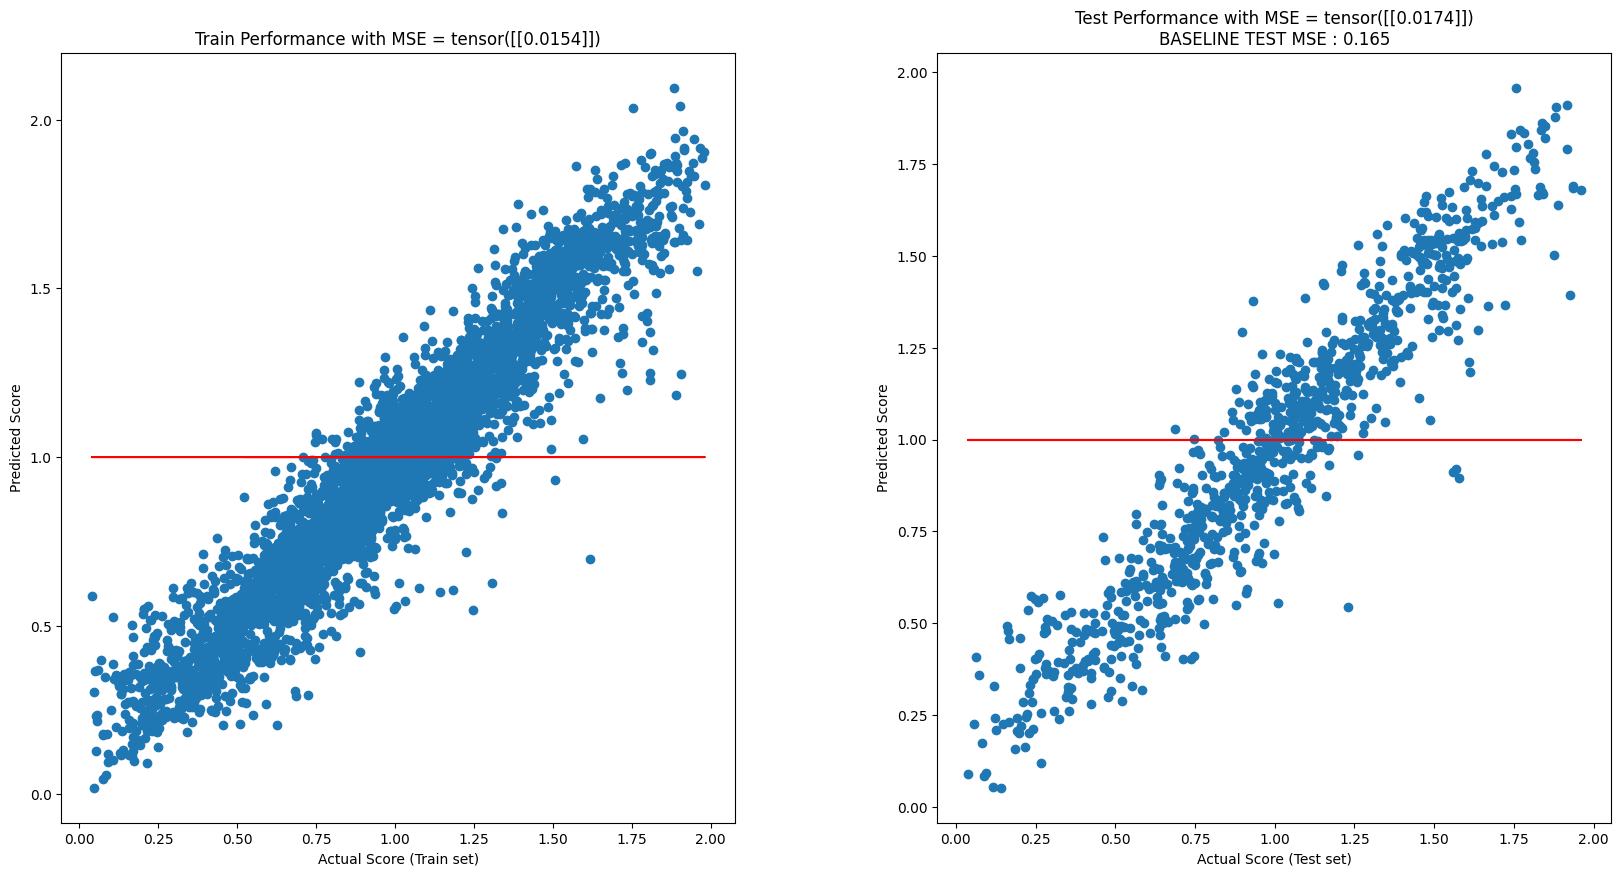

time: 2.12 s (started: 2023-04-10 11:46:47 +00:00)


In [ ]:
elman_test_mse,elman_test_r2=model_eval(model=elman_learned_model,train_data=train_data,test_data=test_data)

#Performance on the sequences with length >9 {This was asked by sir out of assignment}

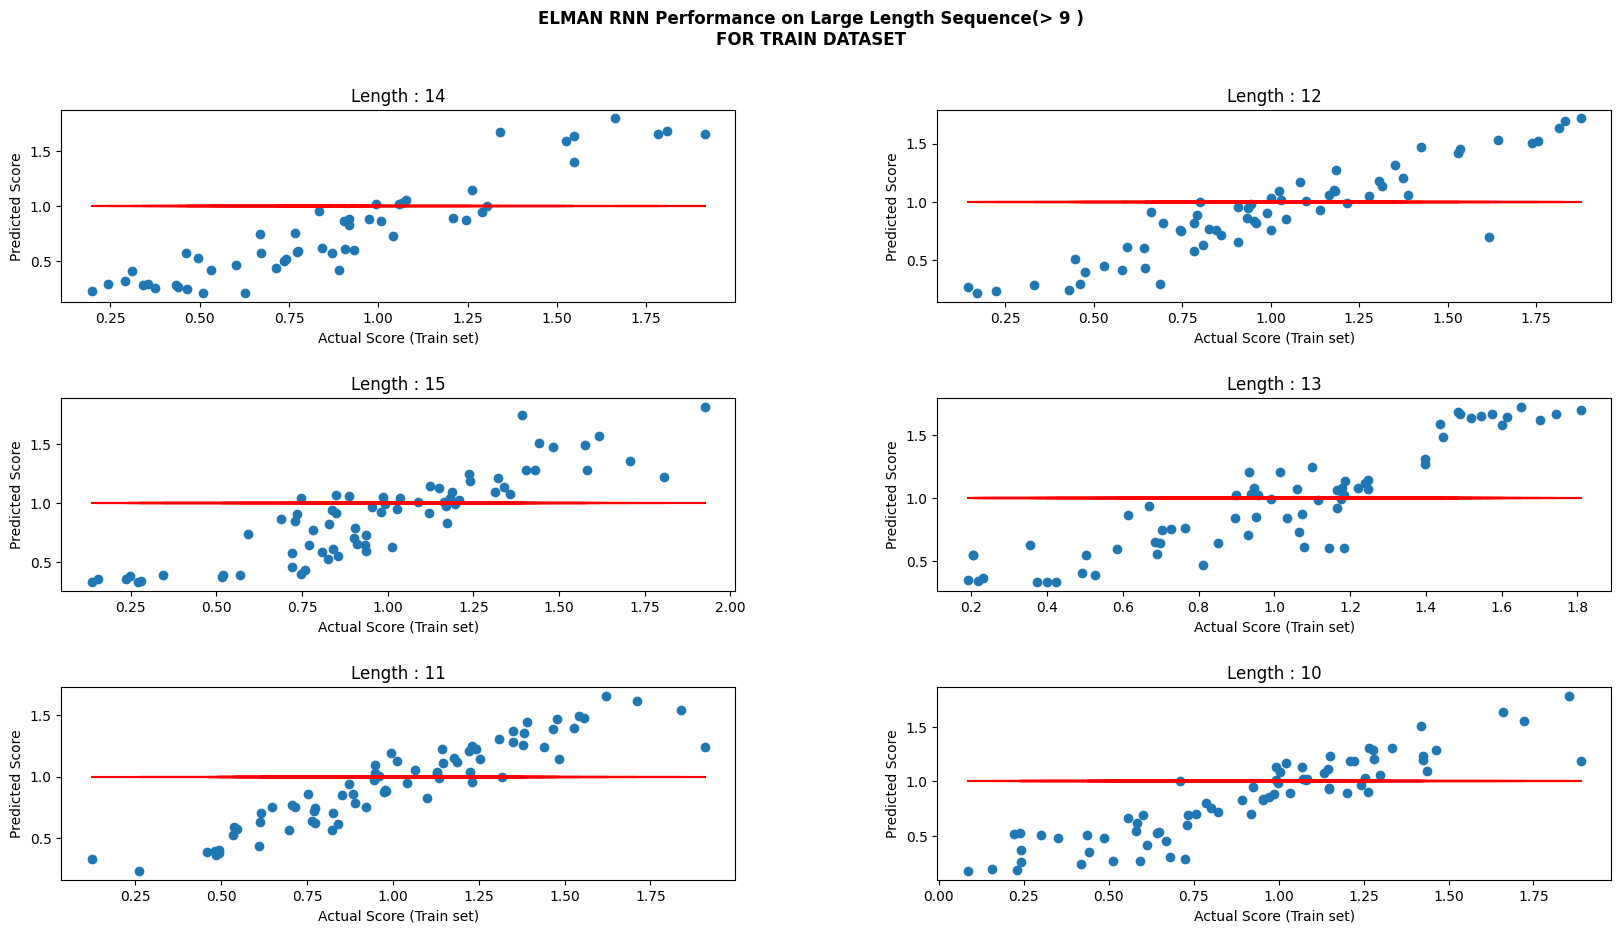

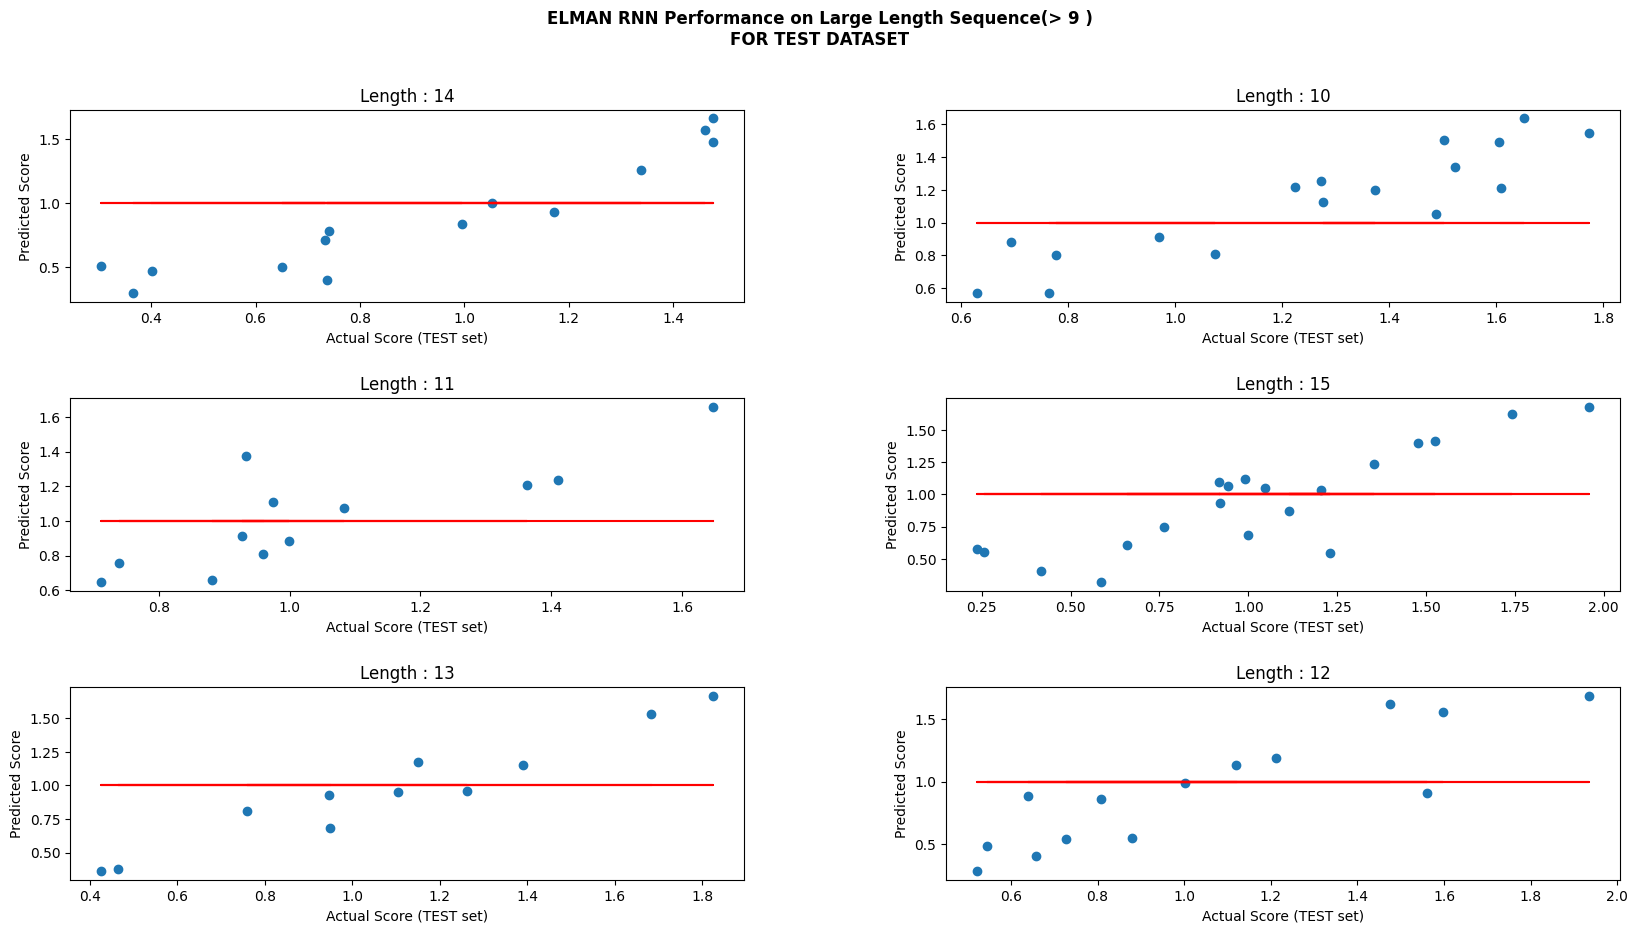

time: 2.56 s (started: 2023-04-10 11:46:49 +00:00)


In [ ]:
model_eval_large_sequences(elman_learned_model,"ELMAN RNN")

#Creating Naive LSTM Class

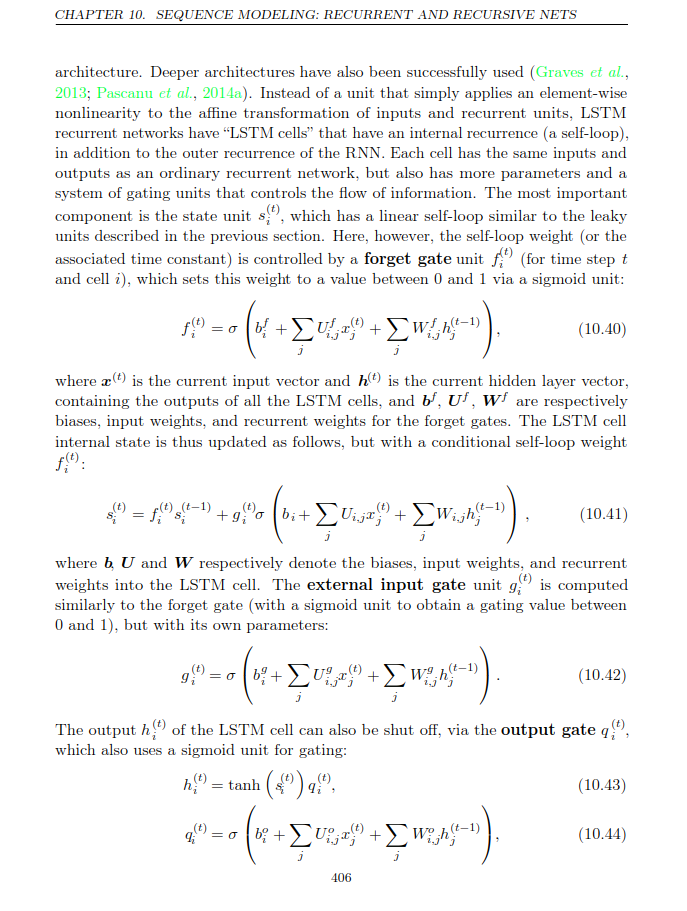

# As can be seen above. It's a page from Ian goodfellow's book "Deep Learning" ,Chapter 10: Sequence Models. According to it, all the gates (forget,input,output) has 2 weight matrices + 1 bias matrix involved in their linear combination based definition.

In [ ]:
class Naive_LSTM(nn.Module):
    def __init__(self, input_seq_size, hidden_state_size,output_size):
        super(Naive_LSTM, self).__init__()
        self.input_seq_size=input_seq_size
        self.hidden_state_size=hidden_state_size
        self.output_size=output_size
        #parametrs matrices for input gate
        self.itoh_i = nn.Parameter(torch.randn(self.input_seq_size, self.hidden_state_size))
        self.htoh_i = nn.Parameter(torch.randn(self.hidden_state_size, self.hidden_state_size))
        self.bias_i = nn.Parameter(torch.randn(self.hidden_state_size))
        
        #parametrs matrices for forget gate
        self.itoh_f = nn.Parameter(torch.randn(self.input_seq_size, self.hidden_state_size))
        self.htoh_f = nn.Parameter(torch.randn(self.hidden_state_size, self.hidden_state_size))
        self.bias_f = nn.Parameter(torch.randn(self.hidden_state_size))
        
        #parametrs matrices for current temporary cell state
        self.itoh_c = nn.Parameter(torch.randn(self.input_seq_size, self.hidden_state_size))
        self.htoh_c = nn.Parameter(torch.randn(self.hidden_state_size, self.hidden_state_size))
        self.bias_c = nn.Parameter(torch.randn(self.hidden_state_size))
        
        #parametrs matrices for output gate
        self.itoh_o = nn.Parameter(torch.randn(self.input_seq_size, self.hidden_state_size))
        self.htoh_o = nn.Parameter(torch.randn(self.hidden_state_size, self.hidden_state_size))
        self.bias_o = nn.Parameter(torch.randn(self.hidden_state_size))

        # parameters to get final Output
        self.htopred_y = nn.Parameter(torch.randn(self.hidden_state_size, self.output_size))
        self.bias_y = nn.Parameter(torch.randn(self.output_size))
        
        #self.init_weights()

    # def init_weights(self):
    #     stdv = 1.0 / math.sqrt(self.hidden_size)
    #     for weight in self.parameters():
    #         weight.data.uniform_(-stdv, stdv)    
          

    def forward(self, input_seq):
          # Initialize hidden state and cell state
        h_t = torch.zeros(1, self.hidden_state_size)
        c_t = torch.zeros(1, self.hidden_state_size)

        # Iterate over the input sequence
        for t in range(input_seq.shape[0]):
            x_t = input_seq[t]

            # Input gate
            i_t = torch.sigmoid(torch.matmul(x_t, self.itoh_i) + torch.matmul(h_t, self.htoh_i) + self.bias_i)
            #print("i_t",i_t.shape)
            # Forget gate
            f_t = torch.sigmoid(torch.matmul(x_t, self.itoh_f) + torch.matmul(h_t, self.htoh_f) + self.bias_f)
            #print("f_t",f_t.shape)
            # Memory cell
            g_t = torch.tanh(torch.matmul(x_t, self.itoh_c) + torch.matmul(h_t, self.htoh_c) + self.bias_c)
            #print("g_t",g_t.shape)
            # Update cell state
            c_t = f_t * c_t + i_t * g_t
            #print("c_t",c_t.shape)
            # Output gate
            o_t = torch.sigmoid(torch.matmul(x_t, self.itoh_o) + torch.matmul(h_t, self.htoh_o) + self.bias_o)
            #print("o_t",o_t.shape)
            # Update hidden state
            h_t = o_t * torch.tanh(c_t)
            #print("h_t",h_t.shape)
        # Output layer
        y_t = torch.matmul(h_t, self.htopred_y) + self.bias_y
        #print("y_t",y_t.shape)
        return y_t



time: 2.05 ms (started: 2023-04-10 11:46:52 +00:00)


#Training LSTM

In [ ]:
LSTM_learned_model,LSTM_train_loss_per_epoch,LSTM_train_r2_per_epoch,LSTM_convergence_epochs,LSTM_convergence_time=train_rnn(model_object=Naive_LSTM,train_data=train_data,input_seq_size=2,hidden_state_size=16,output_size=1)

 ***** Executing Epoch : 1 ******
 ^^^^ Train Loss : 0.5093231718341599 & Train R2 : -2.0125976786820137 ^^^^^
 ***** Executing Epoch : 2 ******
 ^^^^ Train Loss : 0.0553942897564128 & Train R2 : 0.6723480910461359 ^^^^^
 ***** Executing Epoch : 3 ******
 ^^^^ Train Loss : 0.021625670628249615 & Train R2 : 0.8720862321909144 ^^^^^
 ***** Executing Epoch : 4 ******
 ^^^^ Train Loss : 0.010344825705846635 & Train R2 : 0.93881134809709 ^^^^^
 ***** Executing Epoch : 5 ******
 ^^^^ Train Loss : 0.005617631200994605 & Train R2 : 0.9667722498906154 ^^^^^
 ***** Executing Epoch : 6 ******
 ^^^^ Train Loss : 0.0033633673599464302 & Train R2 : 0.9801060046103598 ^^^^^
 ***** Executing Epoch : 7 ******
 ^^^^ Train Loss : 0.0022549281350769616 & Train R2 : 0.9866623166624097 ^^^^^
 ***** Executing Epoch : 8 ******
 ^^^^ Train Loss : 0.001863591953639279 & Train R2 : 0.9889770323405952 ^^^^^
time: 2min 5s (started: 2023-04-10 11:46:52 +00:00)


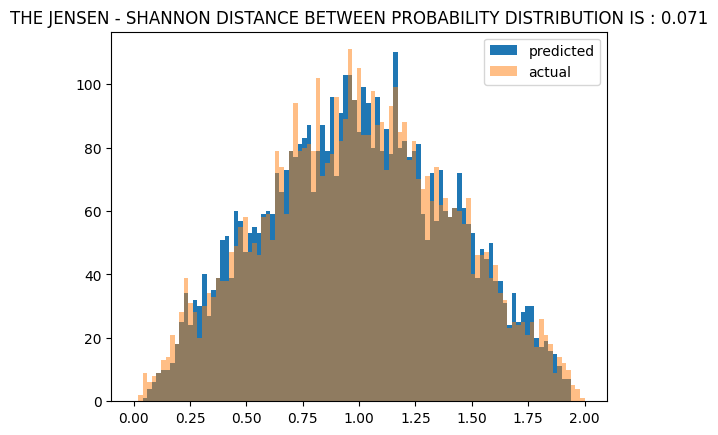

time: 6.32 s (started: 2023-04-10 11:48:58 +00:00)


In [ ]:
jensenshannon_distance(LSTM_learned_model,train_data,test_data)

In [ ]:
#print([x for x in LSTM_learned_model.parameters()][-1])

time: 271 µs (started: 2023-04-10 11:49:04 +00:00)


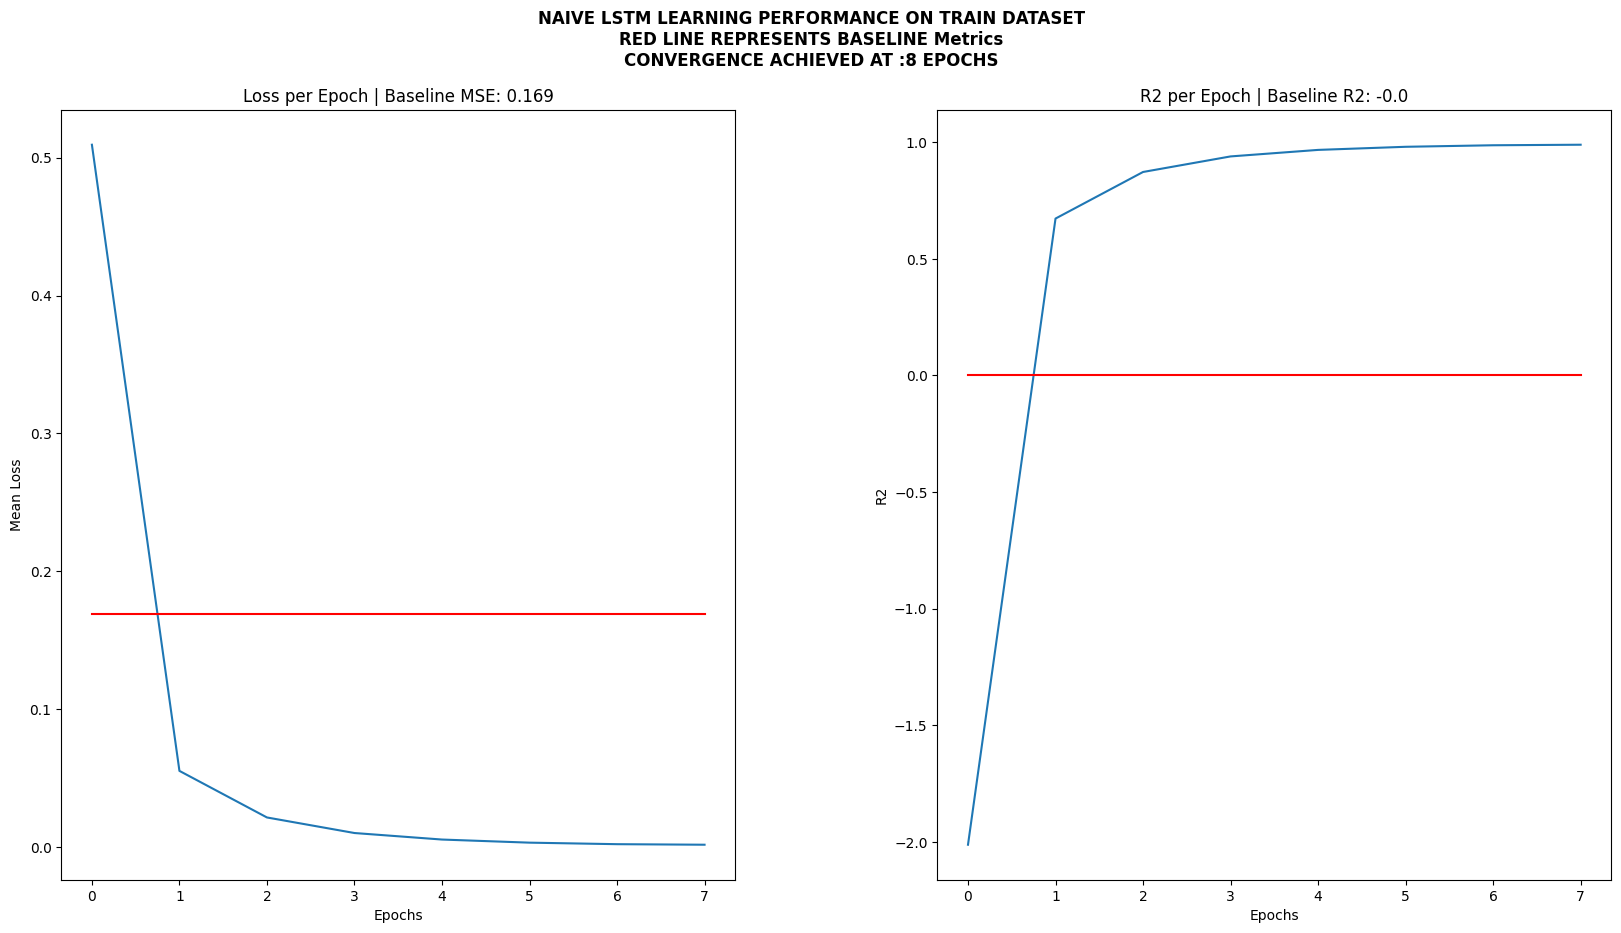

time: 591 ms (started: 2023-04-10 11:49:04 +00:00)


In [ ]:
plot_learning_curves(max_epochs=LSTM_convergence_epochs,train_loss_per_epoch=LSTM_train_loss_per_epoch,train_r2_per_epoch=LSTM_train_r2_per_epoch,model_name="NAIVE LSTM")

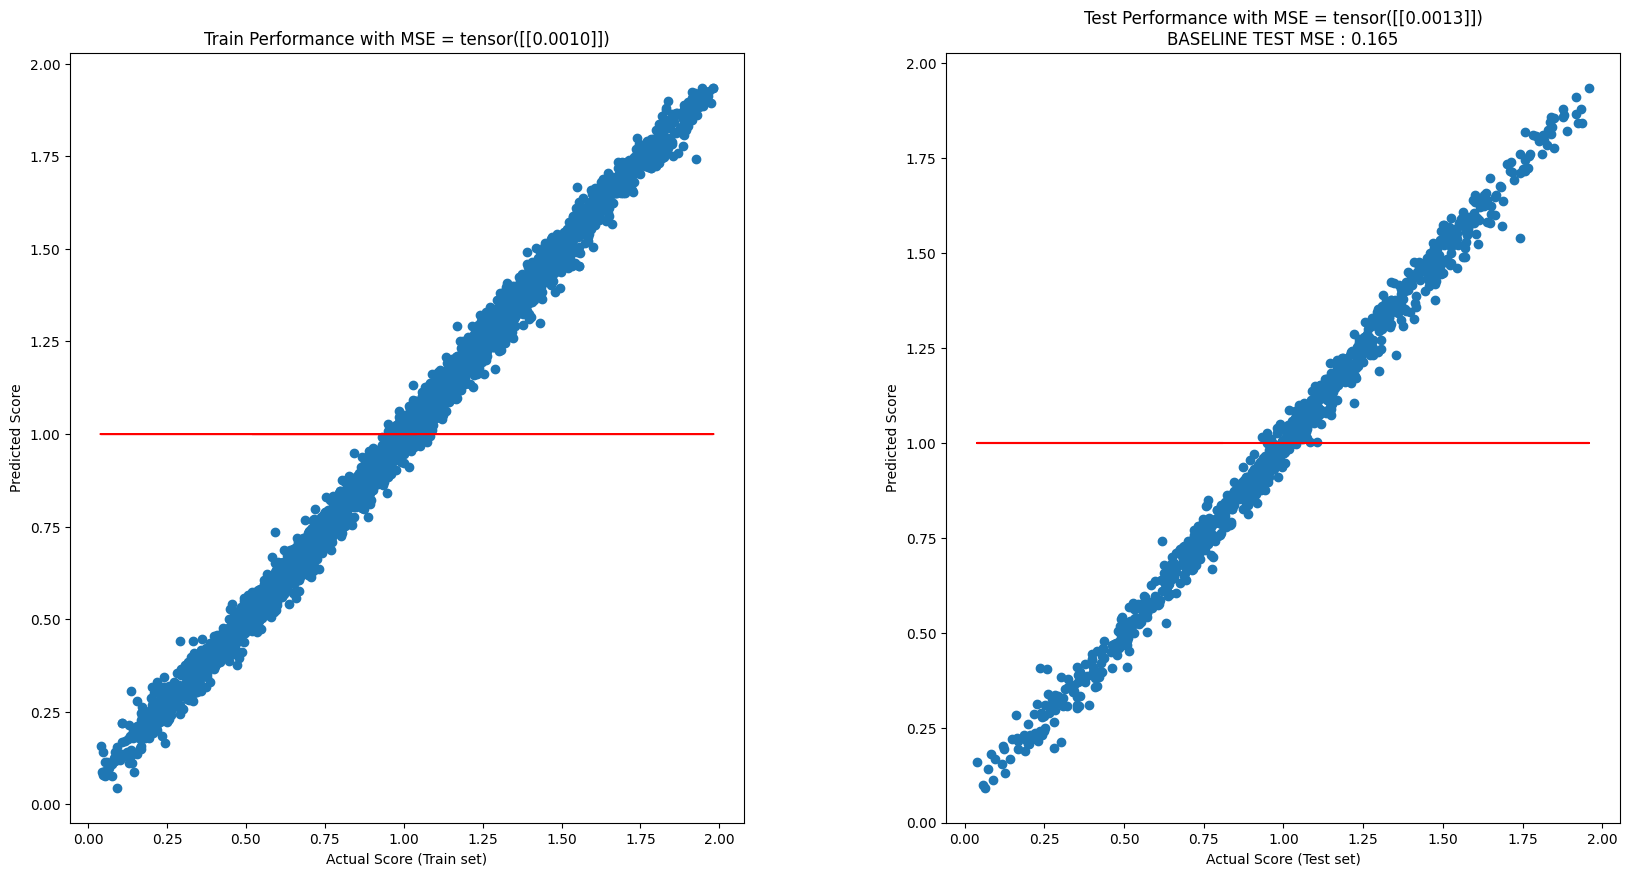

time: 4.21 s (started: 2023-04-10 11:49:05 +00:00)


In [ ]:
LSTM_test_mse,LSTM_test_r2=model_eval(model=LSTM_learned_model,train_data=train_data,test_data=test_data)

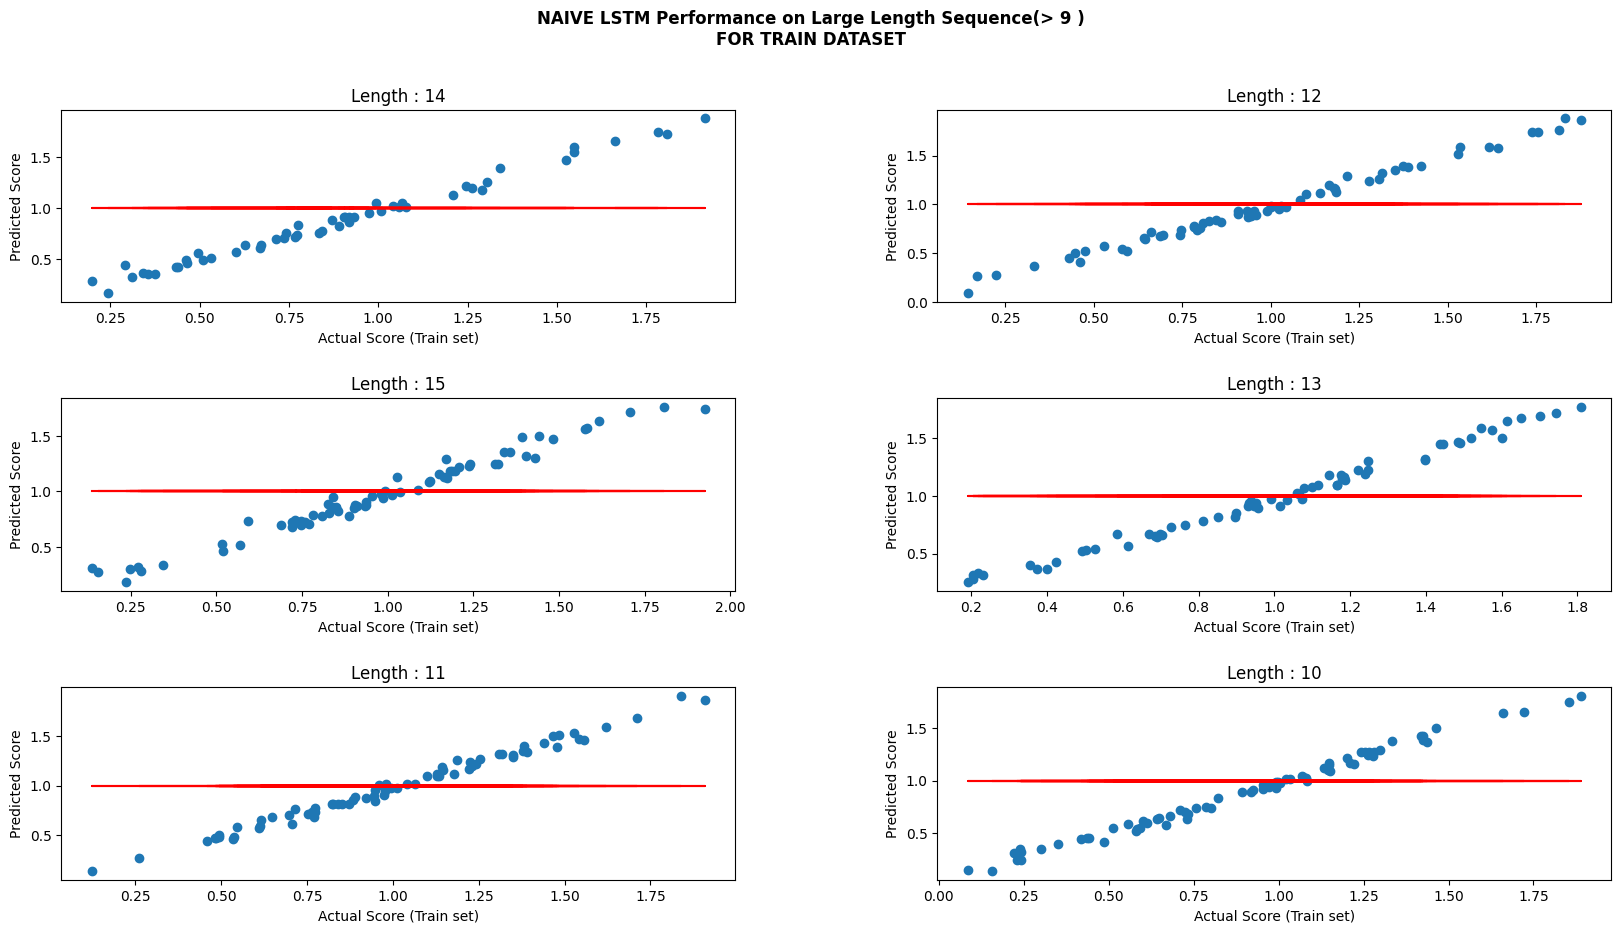

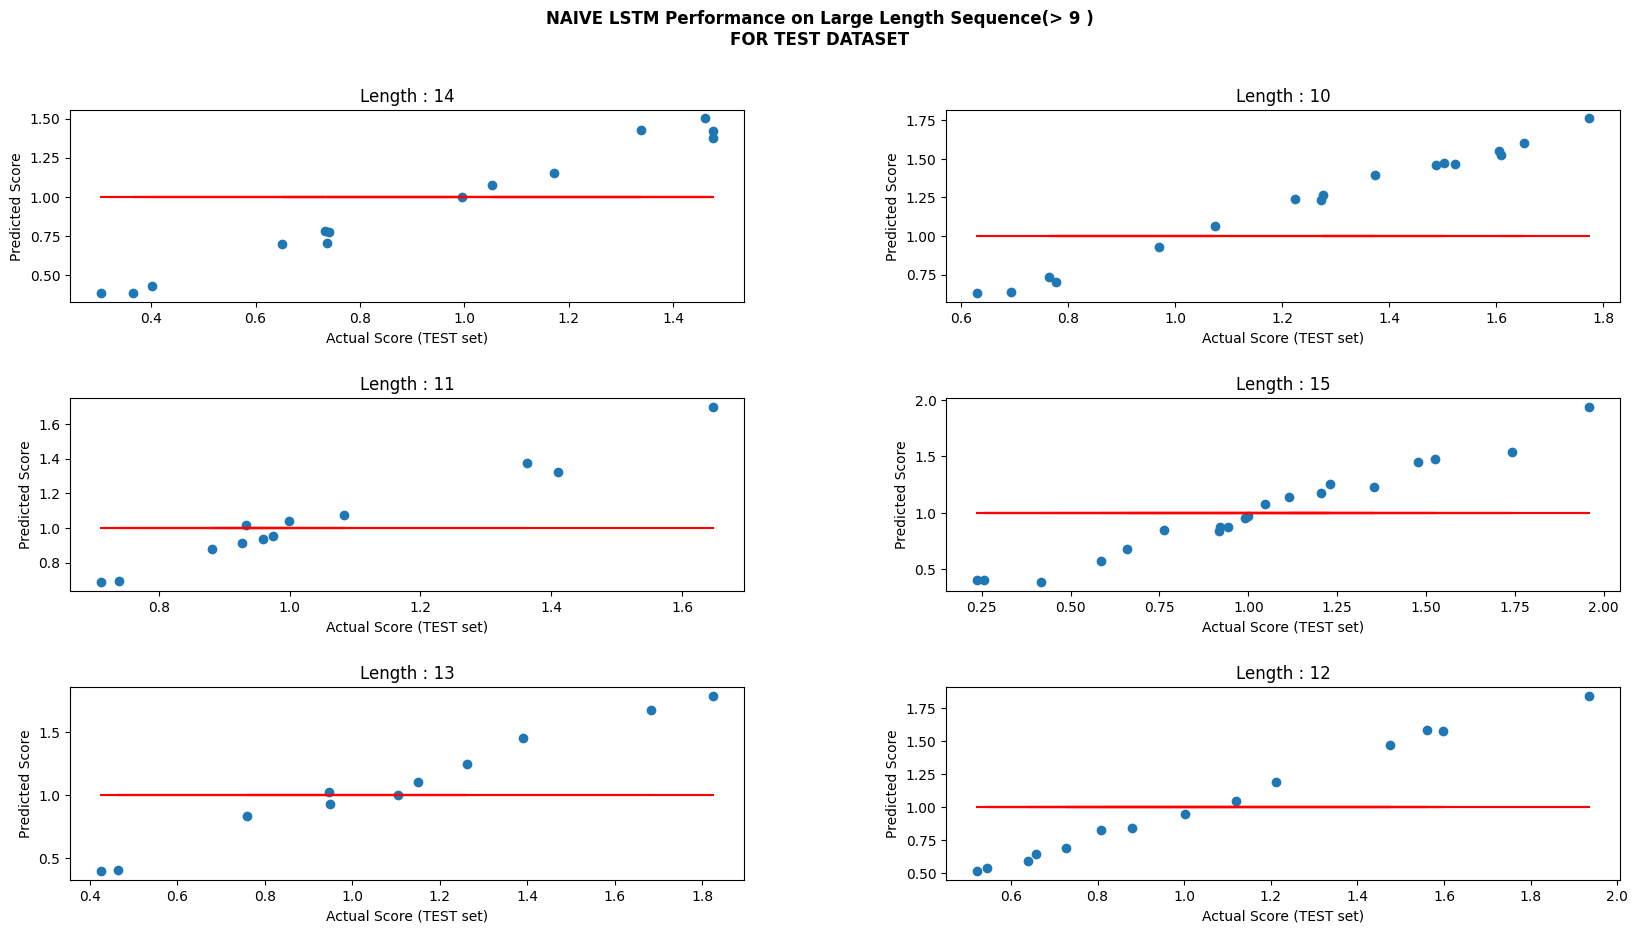

time: 3.01 s (started: 2023-04-10 11:49:09 +00:00)


In [ ]:
model_eval_large_sequences(LSTM_learned_model,"NAIVE LSTM")

#Creating Naive GRU Class


In [ ]:
class Naive_GRU(nn.Module):
    def __init__(self, input_seq_size, hidden_state_size,output_size):
        super(Naive_GRU, self).__init__()

        self.input_seq_size = input_seq_size
        self.hidden_state_size = hidden_state_size
        self.output_size = output_size

        # Reset gate parameters
        self.itoh_r = nn.Parameter(torch.randn(self.input_seq_size, self.hidden_state_size))
        self.htoh_r = nn.Parameter(torch.randn(self.hidden_state_size, self.hidden_state_size))
        self.bias_r = nn.Parameter(torch.randn(self.hidden_state_size))

        # Update gate parameters
        self.itoh_z = nn.Parameter(torch.randn(self.input_seq_size, self.hidden_state_size))
        self.htoh_z = nn.Parameter(torch.randn(self.hidden_state_size, self.hidden_state_size))
        self.bias_z = nn.Parameter(torch.randn(self.hidden_state_size))

        # current memory cell parameters
        self.itoh_c = nn.Parameter(torch.randn(self.input_seq_size, self.hidden_state_size))
        self.htoh_c = nn.Parameter(torch.randn(self.hidden_state_size, self.hidden_state_size))
        self.bias_c = nn.Parameter(torch.randn(self.hidden_state_size))

        # Output weights and biases
        self.htopred_o = nn.Parameter(torch.randn(self.hidden_state_size, self.output_size))
        self.bias_o = nn.Parameter(torch.randn(self.output_size))

    

    def forward(self, input_seq):
        # Initialize hidden state
        h_t = torch.zeros(1, self.hidden_state_size)
        c_t=torch.zeros(1, self.hidden_state_size)
        # Loop over input sequence
        for i in range(input_seq.shape[0]):
            # Update gate
            x_t=input_seq[i]
            z_t = torch.sigmoid(torch.matmul(x_t, self.itoh_z) + torch.matmul(h_t, self.htoh_z) + self.bias_z)
            
            # Reset gate
            r_t = torch.sigmoid(torch.matmul(x_t, self.itoh_r) + torch.matmul(h_t, self.htoh_r) + self.bias_r)
            
            # Candidate activation
            c_t = torch.tanh(torch.matmul(x_t, self.itoh_c) + r_t * torch.matmul(h_t, self.htoh_c) + self.bias_c)
            
            # Hidden state
            h_t = (1 - z_t) * c_t + z_t * h_t
        
        # Output
        output = torch.matmul(h_t, self.htopred_o) + self.bias_o
        
        return output


time: 996 µs (started: 2023-04-10 11:49:12 +00:00)


#Training the GRU

In [ ]:
GRU_learned_model,GRU_train_loss_per_epoch,GRU_train_r2_per_epoch,GRU_convergence_epochs,GRU_convergence_time=train_rnn(model_object=Naive_GRU,train_data=train_data,input_seq_size=2,hidden_state_size=16,output_size=1)

 ***** Executing Epoch : 1 ******
 ^^^^ Train Loss : 0.26562249439858127 & Train R2 : -0.5711315718109287 ^^^^^
 ***** Executing Epoch : 2 ******
 ^^^^ Train Loss : 0.021124989820824724 & Train R2 : 0.8750477128909516 ^^^^^
 ***** Executing Epoch : 3 ******
 ^^^^ Train Loss : 0.008191644370136668 & Train R2 : 0.9515472093500619 ^^^^^
 ***** Executing Epoch : 4 ******
 ^^^^ Train Loss : 0.005114446368423074 & Train R2 : 0.9697485405158045 ^^^^^
 ***** Executing Epoch : 5 ******
 ^^^^ Train Loss : 0.0034222816747968114 & Train R2 : 0.9797575323455129 ^^^^^
 ***** Executing Epoch : 6 ******
 ^^^^ Train Loss : 0.0025062497663648005 & Train R2 : 0.9851757731452825 ^^^^^
time: 1min 23s (started: 2023-04-10 11:49:12 +00:00)


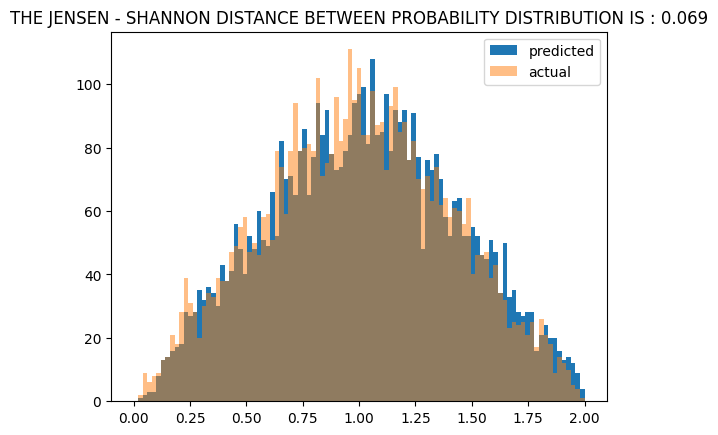

time: 5.57 s (started: 2023-04-10 11:50:36 +00:00)


In [ ]:
jensenshannon_distance(GRU_learned_model,train_data,test_data)

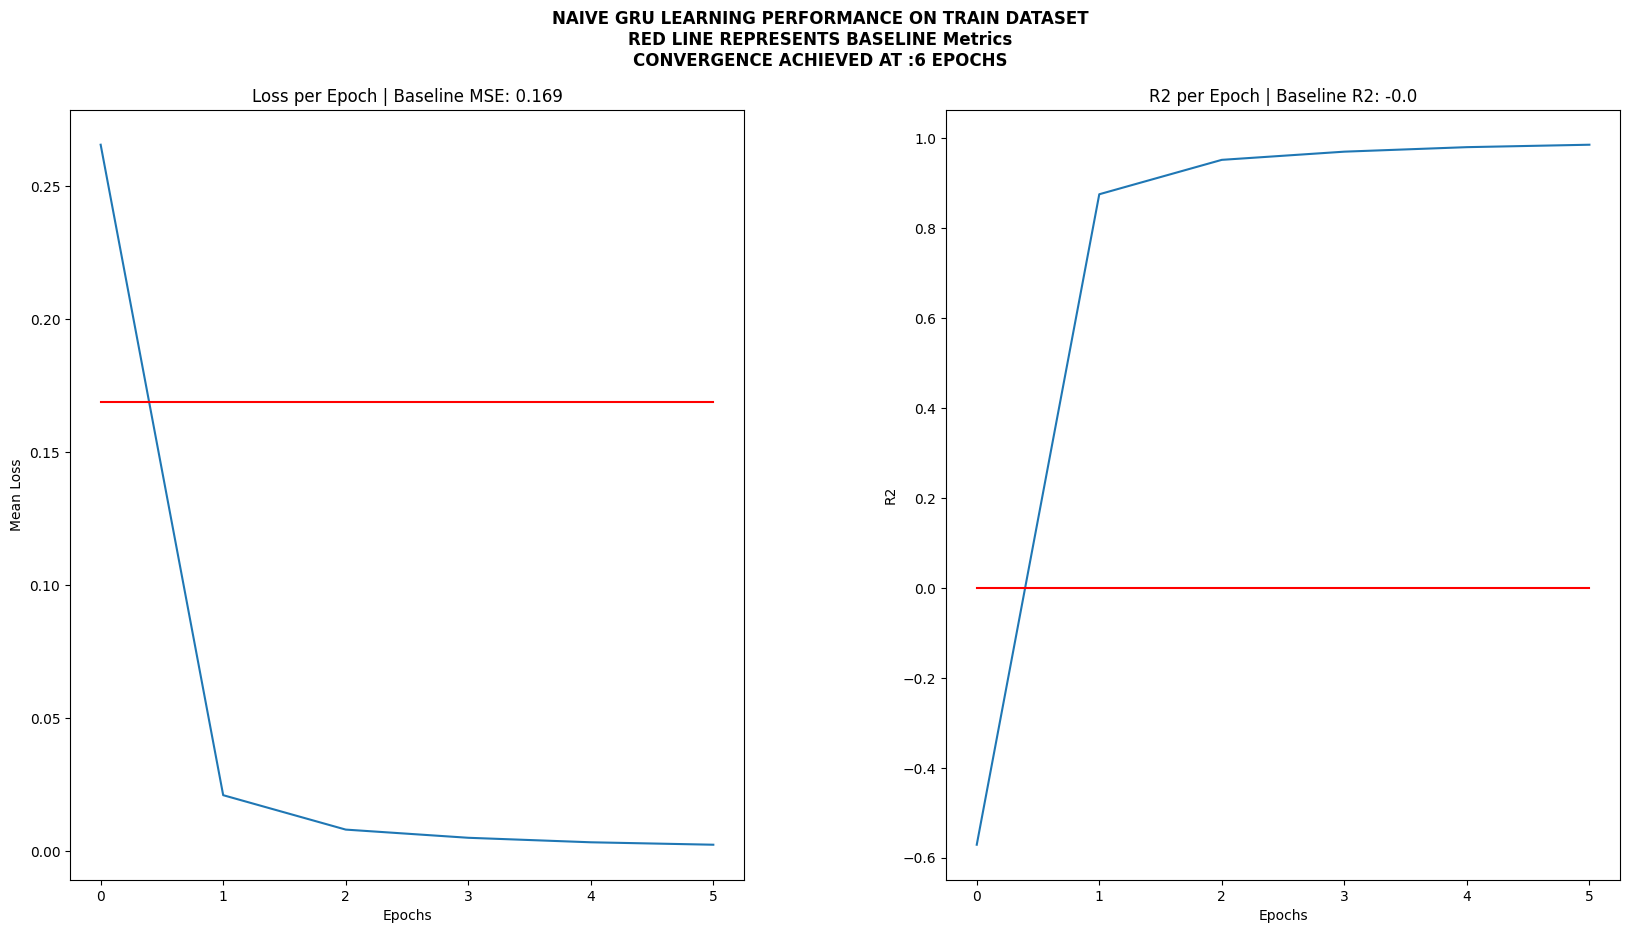

time: 465 ms (started: 2023-04-10 11:50:41 +00:00)


In [ ]:
plot_learning_curves(max_epochs=GRU_convergence_epochs,train_loss_per_epoch=GRU_train_loss_per_epoch,train_r2_per_epoch=GRU_train_r2_per_epoch,model_name="NAIVE GRU")

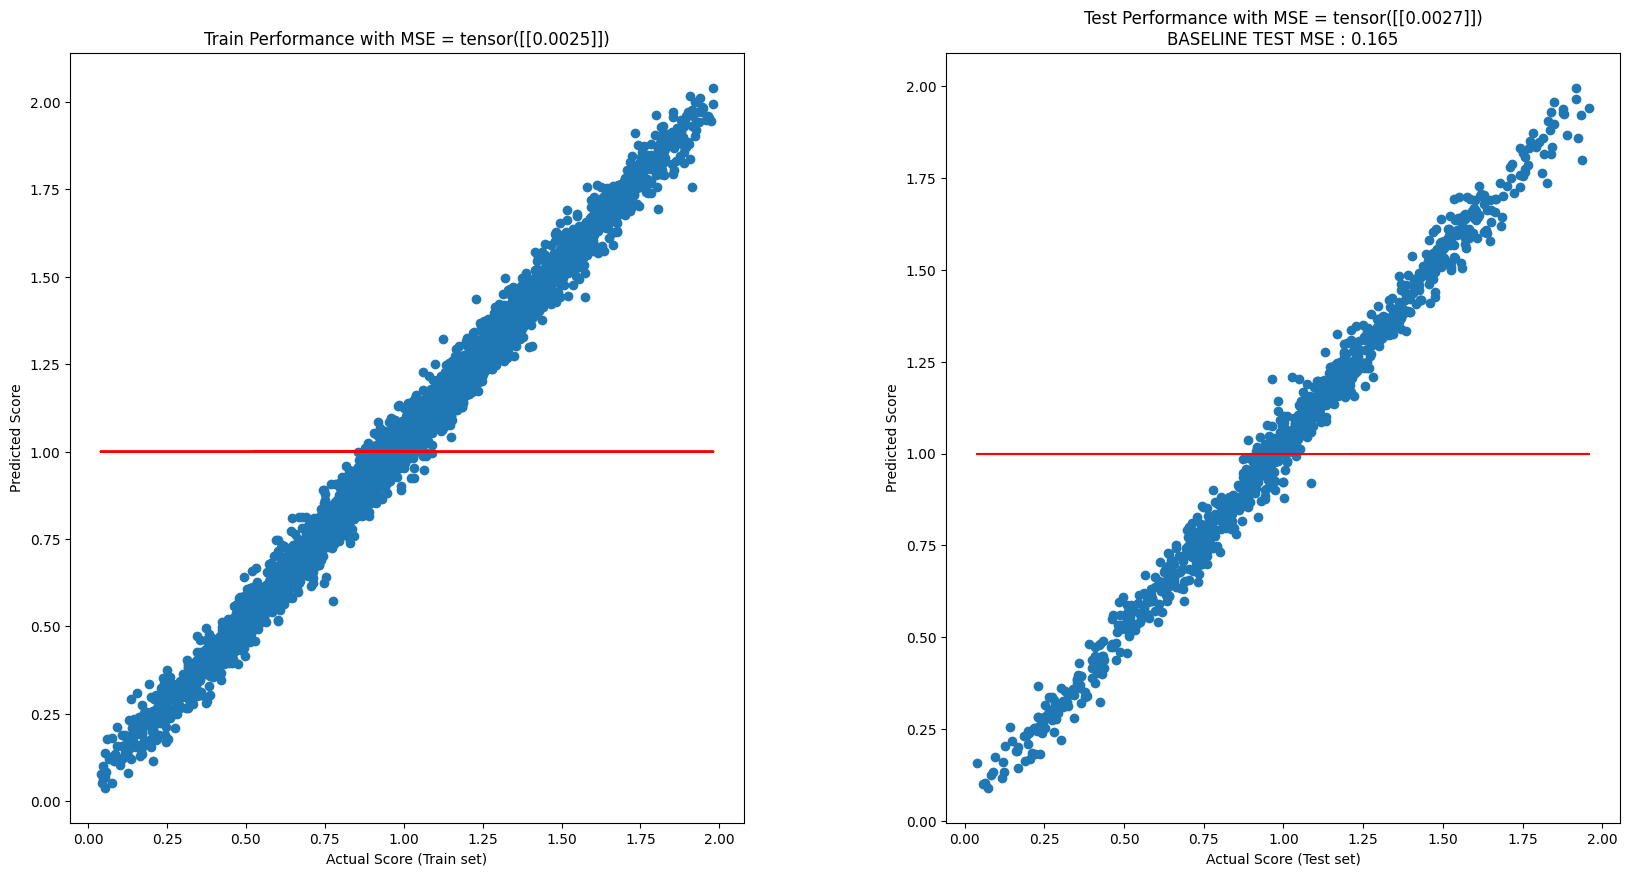

time: 3.93 s (started: 2023-04-10 11:50:42 +00:00)


In [ ]:
GRU_test_mse,GRU_test_r2=model_eval(model=GRU_learned_model,train_data=train_data,test_data=test_data)

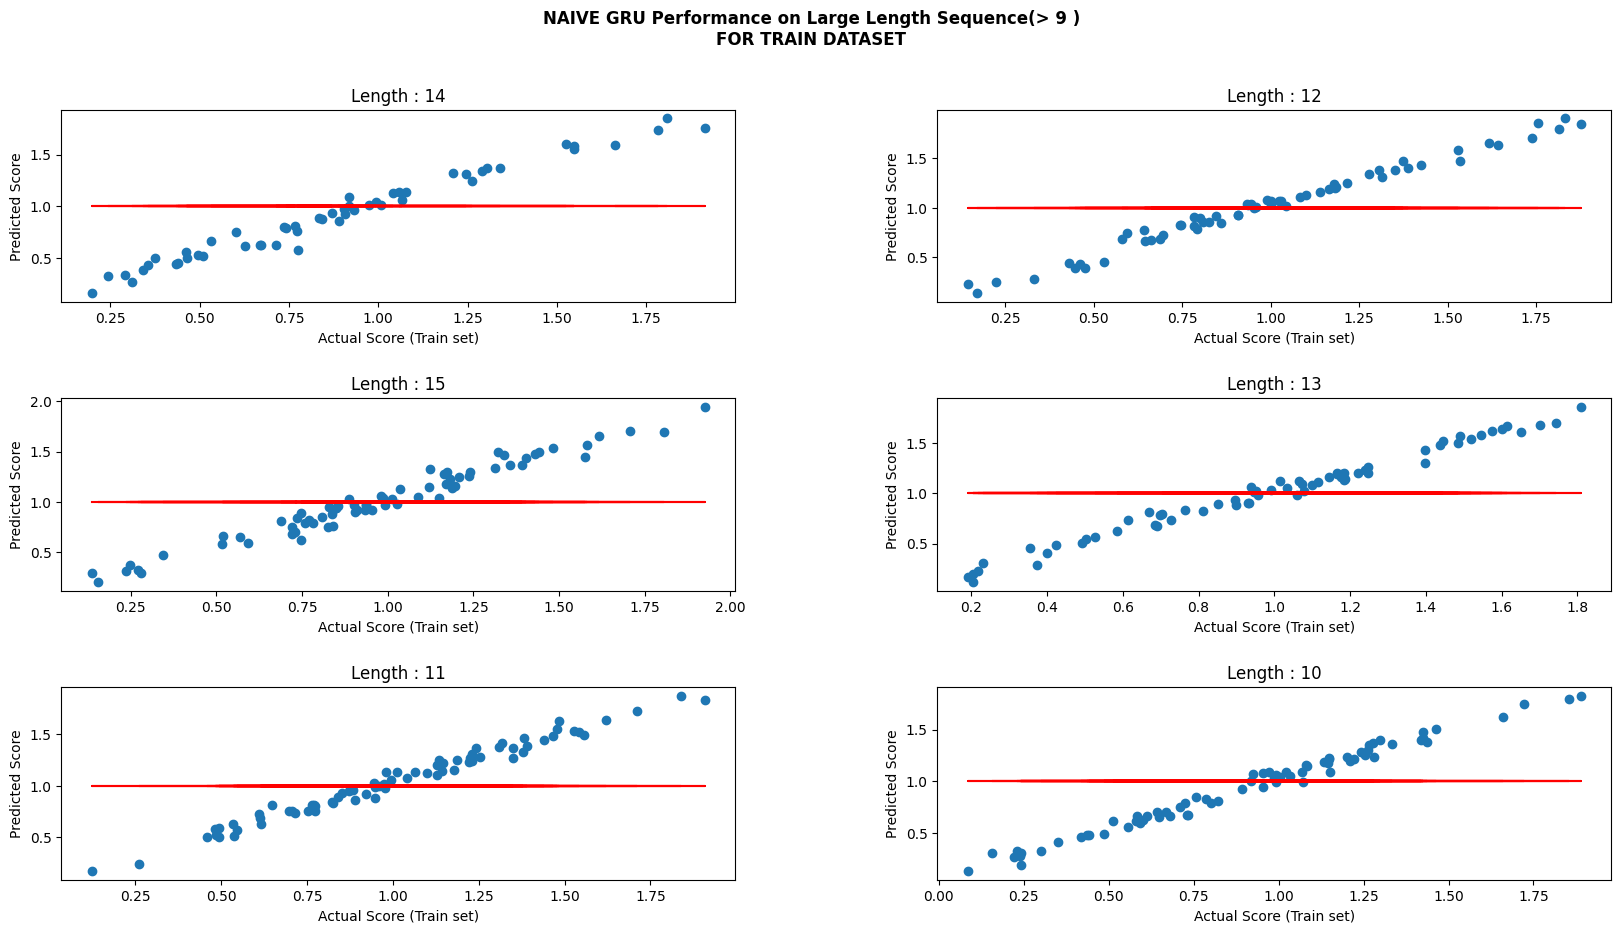

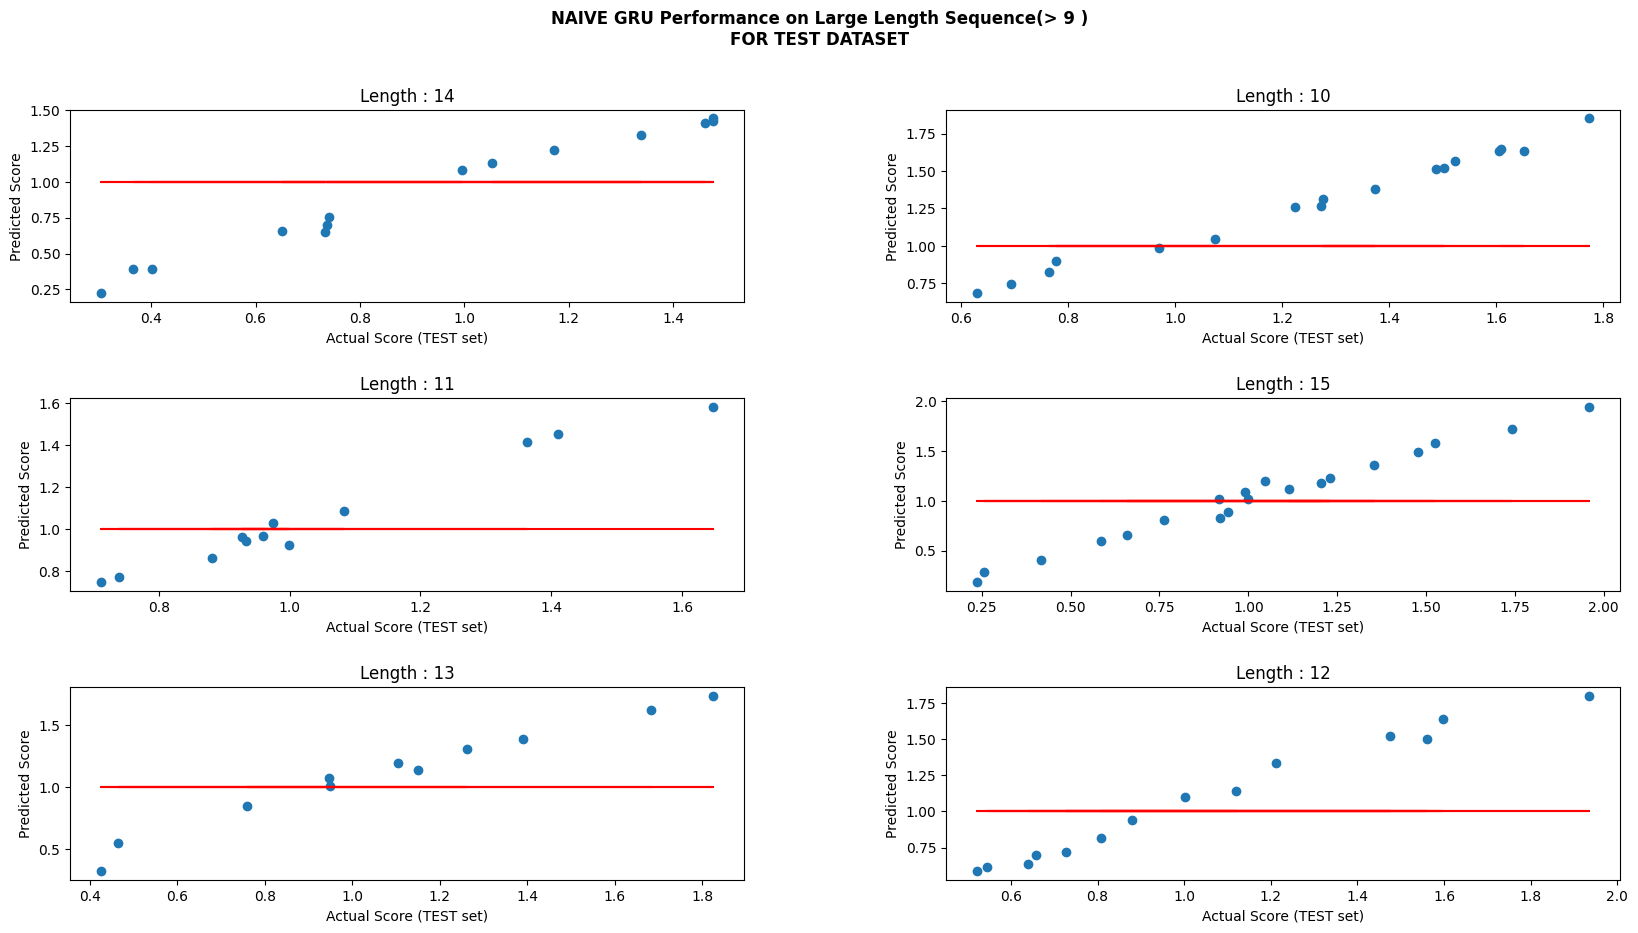

time: 3.22 s (started: 2023-04-10 11:50:46 +00:00)


In [ ]:
model_eval_large_sequences(GRU_learned_model,"NAIVE GRU")

#***FINALLY SUMMARIZING THE PERFORMANCE OF ALL THE 3 RNN's***

In [ ]:
from tabulate import tabulate
summary=pd.DataFrame(columns=['Final_Train_MSE','Test_MSE','Final_Train_R2','Test_R2','Convergence_Epochs'],index=['Elman','LSTM','GRU'])

summary.loc['Elman','Final_Train_MSE']=elman_train_loss_per_epoch[-1]
summary.loc['Elman','Test_MSE']=elman_test_mse
summary.loc['Elman','Final_Train_R2']=elman_train_r2_per_epoch[-1]
summary.loc['Elman','Test_R2']=elman_test_r2
summary.loc['Elman','Convergence_Epochs']=elman_convergence_epochs
summary.loc['Elman','Time_Taken_To_Converge(s)']=elman_convergence_time


summary.loc['LSTM','Final_Train_MSE']=LSTM_train_loss_per_epoch[-1]
summary.loc['LSTM','Test_MSE']=LSTM_test_mse
summary.loc['LSTM','Final_Train_R2']=LSTM_train_r2_per_epoch[-1]
summary.loc['LSTM','Test_R2']=LSTM_test_r2
summary.loc['LSTM','Convergence_Epochs']=LSTM_convergence_epochs
summary.loc['LSTM','Time_Taken_To_Converge(s)']=LSTM_convergence_time

summary.loc['GRU','Final_Train_MSE']=GRU_train_loss_per_epoch[-1]
summary.loc['GRU','Test_MSE']=GRU_test_mse
summary.loc['GRU','Final_Train_R2']=GRU_train_r2_per_epoch[-1]
summary.loc['GRU','Test_R2']=GRU_test_r2
summary.loc['GRU','Convergence_Epochs']=GRU_convergence_epochs
summary.loc['GRU','Time_Taken_To_Converge(s)']=GRU_convergence_time

time: 6.4 ms (started: 2023-04-10 11:50:49 +00:00)


In [ ]:
print(tabulate(summary, headers='keys', tablefmt="fancy_grid"))

╒═══════╤═══════════════════╤═════════════════════════╤══════════════════╤═══════════╤══════════════════════╤═════════════════════════════╕
│       │   Final_Train_MSE │ Test_MSE                │   Final_Train_R2 │   Test_R2 │   Convergence_Epochs │   Time_Taken_To_Converge(s) │
╞═══════╪═══════════════════╪═════════════════════════╪══════════════════╪═══════════╪══════════════════════╪═════════════════════════════╡
│ Elman │        0.017568   │ tensor([[0.0174]])      │         0.896087 │  0.894368 │                  100 │                    498.81   │
├───────┼───────────────────┼─────────────────────────┼──────────────────┼───────────┼──────────────────────┼─────────────────────────────┤
│ LSTM  │        0.00186359 │ [0.001282591954804957]  │         0.988977 │  0.992224 │                    8 │                    125.941  │
├───────┼───────────────────┼─────────────────────────┼──────────────────┼───────────┼──────────────────────┼─────────────────────────────┤
│ GRU   │        0.0